# Summary of this project and my current struggles

In [2]:
import xarray as xr

import notebook_helper

import matplotlib.pyplot as plt

from src import utils, ar_model, stats

## I. Project summary

### Project aim

The overarching aim of this project is to demonstrate that a common block-bootstrapping approach for inferring correlation skill in multi-year forecast assessment is often not fit for purpose. The block-bootstrapping approach for a given set of N validation cases (pairs of observations and E ensemble hindcasts) is as follows:

1. Randomly sample with replacement the N validation cases. To take autocorrelation into account, this is done in blocks of five consecutive cases.

2. For each case, randomly sample with replacement E ensemble members.

3. Compute the Pearson correlation coefficient for the ensemble mean.

4. Repeat steps (1)–(3) many times to create a probability distribution.

5. Calculate the p-value from a two-tailed test of the hypothesis that correlation is 0 (or alternatively, assign significance at $\alpha$ if the percentile-based confidence interval for $1-\alpha$ does not include 0).

This approach can significantly underestimate p-values (or infer significant skill too often) because the series being correlated are generally very short (< 50 years) and have higher serial correlation than the block-bootstrapping approach can account for due to:

- the nature of the variable being assessed (e.g. an index for Atlantic Multidecadal Variability)
- ensemble averaging prior to correlation (e.g. often multi-model means are assessed)
- temporal smoothing prior to correlation (e.g. often 8-year means are assessed)

### Project approach

My approach has been to try and directly test how adequate the block-bootstrap approach is. The answer to this question depends, of course, on:

- the nature of the variable being assessed
- the number of ensemble members averaged
- the level of temporal smoothing applied to the variable prior to correlation
- the length of the signals being correlated
- ...

To test the block-bootstrap, I generate many pairs of observations and ensemble hindcasts that are constructed to be independent of each other (i.e., they are generated such that the null hypothesis of zero correlation is true). 

I then test what proportion of pairs reject the null hypothesis using the block-bootstrapping approach with $\alpha$=0.05. An appropriate statistical test should reject 5$\%$ of the pairs (Tim had a nice suggestion to use a binomial distribution to put confidence intervals on this).

### Generation of independent pairs

Requirements for the process of generating the observations and ensemble hindcasts are:

1. For each pair, the observations and hindcasts are indepedent of each other

2. The pairs are independent of each other

3. Lots of pairs can be generated

3. The observation series look like real observed/reanalysis data (e.g. similar auto-correlation functions)

4. The ensemble hindcast series look like real GCM hindcast data (e.g. similar auto-correlation functions)

It would be great if the process also provides us the ability to readily test different climate variables, ensemble sizes, temporal averages, signal lengths etc.

## II. What am I currently doing to generate independent pairs of observations/hindcasts?

My current approach for generating independent pairs of observations and ensemble hindcasts is as follows:

1. Fit a (V)AR model to represent the variable(s) in question. The model may be fitted to observations or climate model data, for example.

2. Generate a length N synthetic observation timeseries as a length N simulation of the fitted process.

3. Generate a length N synthetic ensemble hindcast by progressing the fitted model forward in time by L lead steps from another (independent) length N simulation of the fitted process. The initial condition for each E ensemble member is the same, but their trajectories differ because the noise component of the model is different for each member.

4. Repeat 2-3 many times to generate many pairs of independent observations/hindcasts to use to test the block-bootstrapping approach

So far, I've been trying to fit (V)AR models to annual indices for the Atlantic Multidecadal Variability (AMV) and North Atlantic Oscillation (NAO) since these indices are used heavily in the multi-year verification literature, especially in analyses of the signal-to-noise paradox, which I think may suffer from issues with block-boostrapping.

## III. What's the problem?

Unfortunately, the approach described above does not produce synthetic multi-year hindcasts with the same level of serial correlation as real GCM hindcasts. Often the synthetic hindcasts have significantly less serial correlation than real GCM hindcasts, and so we tend to underestimate the ineptitude of the block-bootstrap.

To demonstrate this, let's fit an order 2 VAR model to winter AMV and NAO indices calculated from 164 years of historical CMIP6 data:

In [3]:
historical = notebook_helper.load_historical()

In [4]:
params = ar_model.fit(historical, n_lags=2).mean("member")

We can generate many synthetic ensemble hindcasts from this VAR model using the approach described in **II.** and compare these to real GCM hindcasts. 

In the following, we load 115-member, multi-model, year 2-9 average hindcasts of winter AMV and NAO indices from the CMIP6 Decadal Climate Prediction Project (DCPP) and generate 50 synthetic year 2-9 average hindcasts with same the number of time points and ensemble members as the DCPP hindcasts.

In [5]:
dcpp_hindcast = notebook_helper.load_dcpp_hindcasts()
dcpp_hindcast = utils.get_hindcast_mean(dcpp_hindcast, mean_lead_range=[(0, 8)])

In [6]:
n_samples = 50

synth_hindcast = ar_model.generate_samples(
    params,
    n_times=dcpp_hindcast.sizes["time"],
    n_samples=n_samples,
    n_members=dcpp_hindcast.sizes["member"],
    rolling_means=[8],
)

The following plots show the partial autocorrelation functions of the DCPP ensemble-mean hindcasts (red lines) and of 50 synthetic ensemble mean hindcasts (grey lines). It is clear that the lag 1 partial autocorrelation of the AMV hindcasts (left panel) is far too low in the synthetic hindcasts.

In [7]:
synth_acf = stats.acf(synth_hindcast.mean("member"), partial=True, nlags=7)
dcpp_acf = stats.acf(dcpp_hindcast.mean("member"), partial=True, nlags=7)

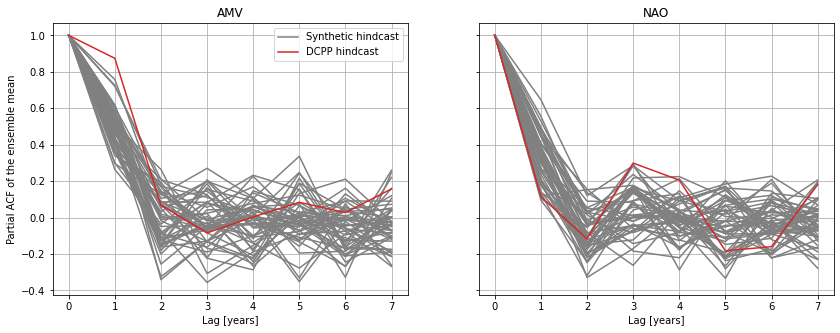

In [8]:
fig = plt.figure(figsize=(14, 5))
axs = fig.subplots(1, len(synth_acf), sharex=True, sharey=True)

for idx, var in enumerate(synth_acf):
    ax = axs[idx]
    _ = synth_acf[var].plot.line(
        ax=ax, x="lag", add_legend=False, label="Synthetic hindcast", color="grey"
    )
    dcpp_acf[var].plot(ax=ax, color="C3", label="DCPP hindcast")
    ax.set_title(var)
    ax.set_xlabel("Lag [years]")
    ax.grid(True)
    if idx == 0:
        ax.set_ylabel("Partial ACF of the ensemble mean")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[0], handles[-1]], [labels[0], labels[-1]])
    else:
        ax.set_ylabel("")

Some things I've tried:

- Fitting an AR model to each index
- Fitting to different input data (e.g reanalysis data or GCM hindcast data)
- Changing the order of the (V)AR model
- Generating synthetic forecasts using ordinary linear regression as the predictive model, run forward in time from initial conditions generated from a (V)AR process

None of these approaches produce synthetic hindcasts with similar ACFs to real GCM forecasts.

## IV. Alternative approaches to generate independent pairs of observations/hindcasts

### Use actual reanalysis and GCM data
One can imagine an approach in which pairs of observations and ensemble mean hindcasts are drawn from existing reanalysis and GCM hindcast datasets in such a way that they are indepedent. This approach has the obvious advantage that the hindcasts will "look like" real GCM hindcasts (because they are). However, given the limited amount of GCM hindcast data available, I'm not sure how such an approach would be possible in practice.

### Fit separate models for the observations and ensemble-mean hindcast data
Instead of fitting a single model and generating sythetic ensemble-mean forecasts using the approach described in **II.**, we could instead generate our synthetic ensemble-mean hindcasts directly from a fit to ensemble-mean GCM hindcasts. This approach should produce sythetic ensemble-mean hindcasts with correct levels of serial correlation, but there are a few cons:

- Different fits are required to test different ensemble sizes
- GCM hindcast records are limited. We would have approximately 50 years of data to fit to, and the max ensemble size that could be tested (without extrapolating parameters) is O(100)

Despite these, this is probably the approach I will pursue absent any better option.